In [1]:
import SimpleITK as sitk

# Always write output to a separate directory, we don't want to pollute the source directory.
import os

OUTPUT_DIR = "./"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [3]:
# nii.gz format
fixed_image = sitk.ReadImage("../volume-covid19-A-0700_day000.nii.gz", sitk.sitkFloat32)
moving_image = sitk.ReadImage("../volume-covid19-A-0700_day007.nii.gz", sitk.sitkFloat32)

# Dicom format
# fixed_reader = sitk.ImageSeriesReader()
# fixed_dicom_names = fixed_reader.GetGDCMSeriesFileNames("./601.000000-COR 3X3-86740")
# fixed_reader.SetFileNames(fixed_dicom_names)
# fixed_image = fixed_reader.Execute()

# moving_reader = sitk.ImageSeriesReader()
# moving_dicom_names = moving_reader.GetGDCMSeriesFileNames("./604.000000-COR 3X3-11320")
# moving_reader.SetFileNames(moving_dicom_names)
# moving_image = moving_reader.Execute()

interact(
    display_images,
    fixed_image_z=(0, fixed_image.GetSize()[2] - 1),
    moving_image_z=(0, moving_image.GetSize()[2] - 1),
    fixed_npa=fixed(sitk.GetArrayViewFromImage(fixed_image)),
    moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)),
);

interactive(children=(IntSlider(value=34, description='fixed_image_z', max=69), IntSlider(value=31, descriptio…

In [4]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
#    sitk.Euler3DTransform(),
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=34, description='image_z', max=69), FloatSlider(value=0.5, description='…

In [9]:
def demons_registration(
    fixed_image, moving_image, fixed_points=None, moving_points=None
):

    registration_method = sitk.ImageRegistrationMethod()

    # Create initial identity transformation.
    transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
    transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    # The image returned from the initial_transform_filter is transferred to the transform and cleared out.
    initial_transform = sitk.DisplacementFieldTransform(
        transform_to_displacment_field_filter.Execute(sitk.Transform())
    )

    # Regularization (update field - viscous, total field - elastic).
    initial_transform.SetSmoothingGaussianOnUpdate(
        varianceForUpdateField=0.0, varianceForTotalField=2.0
    )

    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsDemons(
        10
    )  # intensities are equal if the difference is less than 10HU

    # Multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8, 4, 0])

    registration_method.SetInterpolator(sitk.sitkLinear)
    # If you have time, run this code as is, otherwise switch to the gradient descent optimizer
    # registration_method.SetOptimizerAsConjugateGradientLineSearch(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=50,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
#     if fixed_points and moving_points:
#         registration_method.AddCommand(
#             sitk.sitkStartEvent, rc.metric_and_reference_start_plot
#         )
#         registration_method.AddCommand(
#             sitk.sitkEndEvent, rc.metric_and_reference_end_plot
#         )
#         registration_method.AddCommand(
#             sitk.sitkIterationEvent,
#             lambda: rc.metric_and_reference_plot_values(
#                 registration_method, fixed_points, moving_points
#             ),
#         )

    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(
        sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
    )
    registration_method.AddCommand(
        sitk.sitkIterationEvent, lambda: plot_values(registration_method)
    )
    
    tx = registration_method.Execute(fixed_image, moving_image)
    
    print(f"Final metric value: {registration_method.GetMetricValue()}")
    print(
        f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
    )
    
    return tx

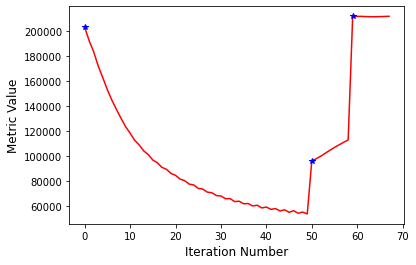

Final metric value: 211830.4788376108
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [10]:
tx = demons_registration(fixed_image, moving_image)

In [11]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    tx,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=34, description='image_z', max=69), FloatSlider(value=0.5, description='…